In [20]:
import json
import os
from os import path as osp
import pandas as pd
import numpy as np
from PIL import Image

In [3]:
split = 'dev'

# download annotations from here and put them in nlxgpt/data :
# https://drive.google.com/drive/folders/16sJjeEQE2o23G-GGUi870ubXzJjdRDua
# (cf. nlxgpt/README.md -> Annotations Download -> VQA-X link)

ann_dir = osp.abspath('../data/')
sample_dir = osp.abspath('../cococaption/results/')

# Preparation

## Read Annotations

In [4]:
def load_json(file): 
    with open(file, 'r') as f:
        data = json.load(f)
    return data

def get_confident_answers(list_of_answers): 
    return [x for x in list_of_answers if x['answer_confidence'] == 'yes']

def majority_vote(list_of_answers):
    answers = [a['answer'] for a in list_of_answers]
    return max(set(answers), key=answers.count)

In [5]:
with open(osp.join(ann_dir, f'CLEVRX_{split}.json')) as f:
    annotations = pd.DataFrame(json.load(f)['questions']).set_index('question_index')

## Read & Prepare Samples

In [6]:
def process_sample_file(filename):
    samples_df = pd.read_json(filename)
    
    # rename question id column & set as index
    samples_df = samples_df.rename(columns={'image_id': 'question_id'}).set_index('question_id')

    # split answers from predictions (and collect idx of entries where this doesn't work)
    samples_df['answers_explanations'] = samples_df.caption.map(lambda x: x.split(' because '))
    invalid_ids = samples_df[samples_df.answers_explanations.map(len) != 2].index
    # restrict to valid samples
    samples_df = samples_df[np.logical_not(samples_df.index.isin(invalid_ids))]

    # separate columns for answers and explanations
    samples_df['answer'] = samples_df.answers_explanations.map(lambda x: x[0])
    samples_df['explanation'] = samples_df.answers_explanations.map(lambda x: x[1])
    samples_df = samples_df.drop(columns=['answers_explanations'])
    
    return samples_df, invalid_ids.to_list()

def is_correct_answer(entry, annotations):
    answer = entry.answer
    question_id = entry.name
    return answer == annotations.loc[question_id].answer

In [7]:
sample_file = osp.join(sample_dir, 'clevrx_unf_captions_full_0.json')
samples_df, invalid_ids = process_sample_file(sample_file)

In [8]:
# determine correctness of predicted answers
samples_df['correct_answer'] = samples_df.apply(lambda x: is_correct_answer(x, annotations), axis=1)
print('clr acc:', round(sum(samples_df.correct_answer) / len(samples_df), 2))

clr acc: 0.65


# show examples

In [48]:
_anns = annotations.rename(columns={'answer': 'ann_answer', 'factual_explanation': 'ann_explanations'})[['question', 'image_filename', 'image_index', 'ann_answer', 'ann_explanations']]

examples = pd.merge(
    samples_df,
    _anns,
    left_index=True,
    right_index=True
)


In [49]:
def show_example(entry, img_dir='PATH'):
    img_filename = osp.join(img_dir, entry.image_filename)
    display(Image.open(img_filename))
    d = dict(entry)
    for key in d.keys():
        print(f'{key}:\t{d[key]}')

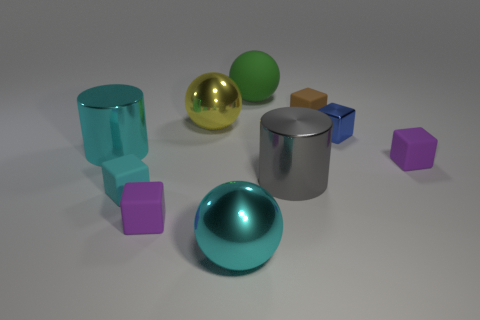

caption:	rubber because the tiny cube to the right of the blue cube is matte
answer:	rubber
explanation:	the tiny cube to the right of the blue cube is matte
correct_answer:	True
question:	What material is the tiny cube that is to the right of the blue thing?
image_filename:	CLEVR_train_000003.png
image_index:	3
ann_answer:	rubber
ann_explanations:	['The tiny cube to the right of a blue block is matte.', 'There is a tiny rubber cube that is to the right of the blue cube.', 'The tiny cube right of a blue cube is rubber.', 'The tiny cube on the right side of a blue block is matte.', 'The tiny cube on the right side of the blue block is matte.', 'The tiny cube right of the blue cube is rubber.']


In [50]:
show_example(examples.iloc[0])